In [179]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [180]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils

from scipy import signal 

In [181]:
%matplotlib notebook

In [182]:
%sql sqlite:///schema/test.db

u'Connected: None@schema/test.db'

In [183]:
# Create Butterworth filter
def apply_butter(freq_1, freq_2, fs, sig):
    """ Apply second order Butterworth filter to sig
    fs is sampling rate
    """
    sos = sp.signal.butter(
        2, (np.array([freq_1, freq_2]) / (fs / 2)), btype='bandpass', analog=False, output='sos'
    )
    sig = signal.sosfiltfilt(sos, sig)
    return sig

def normalize(sig):
    """ Normalize range and zero-mean the signal
    """
    sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))
    return sig - np.mean(sig)

In [184]:
# Load test data (RCH90b)
cur_experiment_id = 1
result = %sql select data from mic where experiment_id = :cur_experiment_id

mic_1 = np.array(result[0][0])
mic_2 = np.array(result[2][0])

# Median filter the data
mic_1 = signal.medfilt(mic_1, 21)
mic_2 = signal.medfilt(mic_2, 21)

# Zero-mean
mic_1 = mic_1 - np.mean(mic_1)
mic_2 = mic_2 - np.mean(mic_2)

# Butterworth (and normalize and zero-mean)
f1 = 250
f2 = 350
fs = 9.6e6
mic_1_butter = apply_butter(f1, f2, fs, mic_1)
mic_1_butter = normalize(mic_1_butter)

mic_2_butter = apply_butter(f1, f2, fs, mic_2)
mic_2_butter = normalize(mic_2_butter)

Done.


<IPython.core.display.Javascript object>


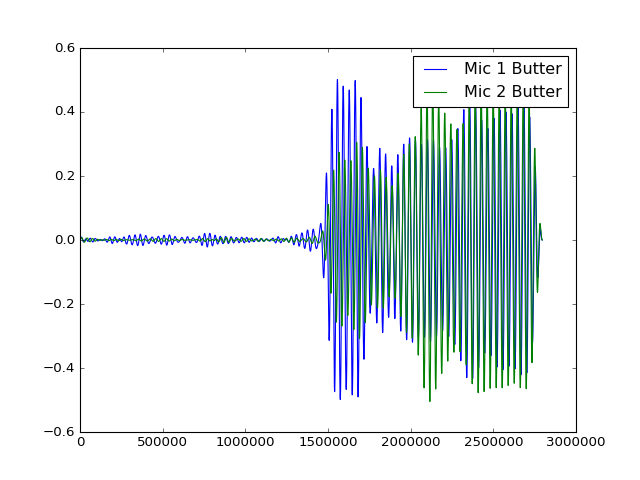

In [185]:
plt.figure(1)
plt.plot(mic_1_butter, label='Mic 1 Butter', lw=1)
plt.plot(mic_2_butter, label='Mic 2 Butter', lw=1)
plt.legend()
plt.show()

[1490548 1523431 1556915 1591945 1628403 1664441 1699445 1735500 1775893
 1813040]
[1501260 1533943 1566984 1601388 1638238 1673389 1707641 1743227 1780830
 1816838]


<IPython.core.display.Javascript object>


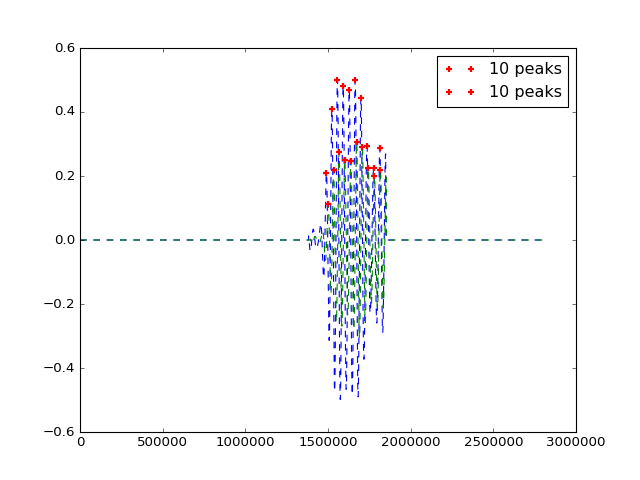

In [186]:
from peakutils.plot import plot as pplot

def get_n_peaks(sig, thres, min_dist, n):
    """ Gets the first n peaks > thres ([0, 1]) and greater than min_dist apart
    """
    idx = peakutils.peak.indexes(sig, thres=thres, min_dist=min_dist)
    return idx[:n]

idx_1 = get_n_peaks(mic_1_butter, 0.6, 1000, 10)
idx_2 = get_n_peaks(mic_2_butter, 0.6, 1000, 10)

print idx_1
print idx_2

sig1 = mic_1_butter
sig2 = mic_2_butter

# Window (Window around first 10 peaks)
sig1[:(idx_1[0]-3*36000)] = 0
sig1[idx_1[-1]+36000:] = 0

sig2[:(idx_2[0]-3*36000)] = 0
sig2[idx_2[-1]+36000:] = 0

plt.figure(2)
pplot(np.arange(len(sig1)), sig1, idx_1)
pplot(np.arange(len(sig2)), sig2, idx_2)

plt.show()

In [187]:
# Window original signals
mic_1_crop = mic_1
mic_2_crop = mic_2

# Window (Window around first 10 peaks)
mic_1_crop[:(idx_1[0]-3*36000)] = 0
mic_1_crop[idx_1[-1]+36000:] = 0

mic_2_crop[:(idx_2[0]-3*36000)] = 0
mic_2_crop[idx_2[-1]+36000:] = 0


In [188]:
# Compute xcorr (using previous code)

import locate

[max_corr, delay] = locate.xcorr(mic_1_crop, mic_2_crop)
print max_corr, delay

148693789.19 8102


<IPython.core.display.Javascript object>


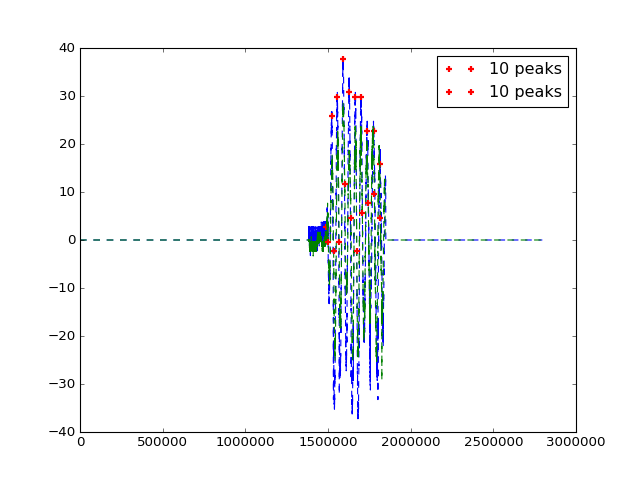

In [190]:
# Plot out optimal xcorr
# NB: np.roll is circular shift, since this is cropped this is fine here.

plt.figure(3)
pplot(np.arange(len(mic_1_crop)), mic_1_crop, idx_1)
pplot(np.arange(len(mic_2_crop)), np.roll(mic_2_crop, -delay), idx_2)